In [155]:
import sys
sys.path.append('..')

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

import autograd.numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from autograd import hessian, grad

from extremevalue.gpd import GPDMLE
rng = np.random.default_rng()

In [122]:
n_sample = 100000
x_data = rng.normal(0.0 ,scale=1.0,size=n_sample)
# x_data = rng.standard_t(df=2.8,size=n_sample)

In [123]:
u = 2.0
x_exceed = x_data[np.where(x_data>u)]-u

In [124]:
xi, _, sigma = sp.stats.genpareto.fit(x_exceed,floc=0.0)
(xi,sigma)

(-0.09450032336759714, 0.4005214638836102)

In [125]:
gpddemo = GPDMLE(u)
gpddemo.fit(x_data)

In [126]:
gpddemo.get_params(include_ci=True)

({'xi': -0.09449561129871772, 'sigma': 0.4005102198979935},
 {'xi': (-0.13436004652778444, -0.054631176069651),
  'sigma': (0.3771698486964593, 0.4238505910995277)})

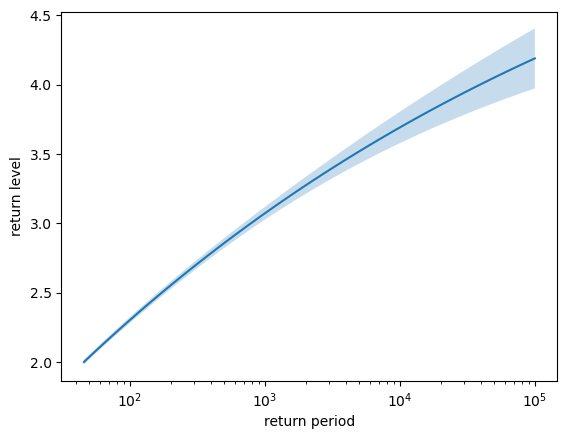

In [127]:
gpddemo.return_level_plot(include_ci=True)

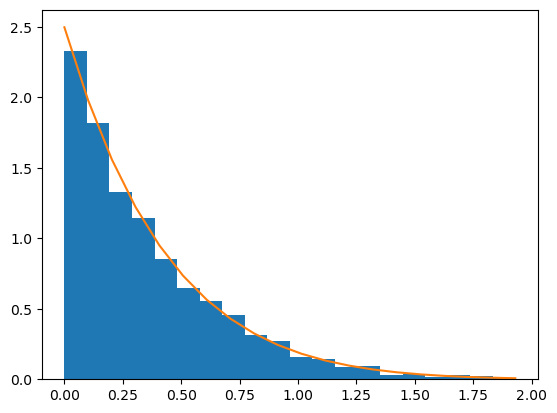

In [128]:
gpddemo.dist_plot()

In [118]:
def period_max(x,period=1):
    n_blocks = len(x)//period
    
    return np.max(np.array_split(x,n_blocks),axis=1)
    

In [ ]:
x_max = period_max(x_data,period=100)
plt.hist(x_max,50)

In [129]:
x_max = period_max(x_data,period=100)
xi, mu, sigma = sp.stats.genextreme.fit(x_max)
xi,  mu, sigma

(0.09879247859921941, 2.3297130692365817, 0.36300310809964026)

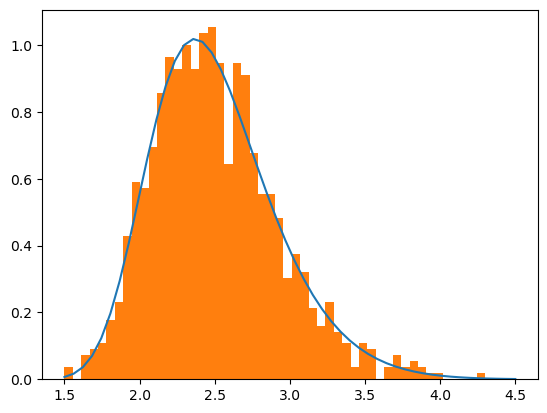

In [130]:
x_vals = np.linspace(1.5,4.5,50)
plt.plot(x_vals,sp.stats.genextreme.pdf(x_vals,xi,loc=mu,scale=sigma))
plt.hist(x_max,50,density=True);

In [165]:
def gev_returnlevel(rl, mu, sigma, xi):
    p = 1.0/rl
    return mu - (sigma/xi)*(1-np.power(-np.log(1.0-p),-xi))

In [132]:
rl = gpddemo._return_periods()
p_vals = 1.0/rl

In [133]:
np.max(x_data), len(x_data)

(4.300609421154048, 100000)

In [207]:
def gev_logp(x, mu, sigma, xi):

    z = (x-mu)/sigma
    return -np.power(1.0+xi*z,-1.0/xi) -(1.0/xi+1.0)*np.log(1.0+xi*z)-np.log(sigma)

def gev_pdf(x, mu, sigma, xi):
    return np.exp(gev_logp(x, mu, sigma, xi))

def gev_returnlevel(rl, mu, sigma, xi):
    p = 1.0/rl
    return mu - (sigma/xi)*(1-np.power(-np.log(1.0-p),-xi))

def gev_sf(x, mu, sigma, xi):
    z = (x-mu)/sigma
    return 1.0 - np.exp(-np.power(1+xi*z,-1.0/xi))


In [238]:
class GEVMLE:
    def __init__(self, period=100):
       
        self.period = period
        self.x_max = None
     
        self.mu = None
        self.sigma = None
        self.xi = None

    def _fit_x_max(self, x):
        n_blocks = len(x)//self.period
        self.x_max = np.max(np.array_split(x,n_blocks),axis=1)
        return x_max
        

    def neg_ll(self, theta) -> float:
        mu, sigma, xi = theta
        return -1.0 * np.sum(gev_logp(self.x_max, mu, sigma, xi))

    def fit(self, x_data, disp=False):

        self._fit_x_max(x_data)

        self.mu, self.sigma, self.xi = sp.optimize.fmin(self.neg_ll,  (1.0, 1.0, 0.001), disp=disp)



    def cov(self) -> np.ndarray:
        fisher_info = hessian(self.neg_ll)(np.array([self.mu, self.sigma, self.xi]))
        cov = np.linalg.inv(fisher_info)
        return cov

    def get_params(self, include_ci=False) -> dict:

        params = {
            "mu" : self.mu,
            "sigma": self.sigma,
            "xi": self.xi
        }

        if include_ci:
            mu_se, sigma_se, xi_se = np.sqrt(np.diag(self.cov()))

            ci = {
                "mu": (self.mu- 2 * mu_se, self.mu+ 2 * mu_se),
                "sigma": (self.sigma - 2 * sigma_se, self.sigma + 2 * sigma_se),
                "xi": (self.xi - 2 * xi_se, self.xi + 2 * xi_se),
               
            }

            return (params, ci)
        else:
            return params

  
    def return_level(self, return_period):

        return gev_returnlevel(
            return_period, self.mu, self.sigma, self.xi, 
        )

    def _return_level_se(self, return_period):
        def rl(theta):
            mu, sigma, xi = theta
            return gev_returnlevel(return_period, mu, sigma, xi )

        delta = grad(rl)(np.array([self.mu, self.sigma, self.xi ]))

        cov = self.cov()

        return np.sqrt((delta.dot(cov)).dot(delta))

    def return_level_se(self, return_period):

        return np.vectorize(self._return_level_se)(return_period)

    def _return_periods(self, n=20, log_scale=True):

        n_start = 2
        n_end = len(self.x_max)

        if log_scale:
            rl = np.exp(np.linspace(np.log(n_start), np.log(n_end), n))
        else:
            rl = np.linspace(n_start, n_end, n)
        return rl

    def return_level_plot(self, include_ci=False, log_scale=True, period=1.0):

        rp = self._return_periods(n=50, log_scale=log_scale)
        rl = self.return_level(rp)

        rp_scaled = rp / period

        plt.plot(rp_scaled, rl)

        if include_ci:
            rl_se = self.return_level_se(rp)
            plt.fill_between(rp_scaled, rl - 2.0 * rl_se, rl + 2.0 * rl_se, alpha=0.25)

        plt.xlabel("return period")
        plt.ylabel("return level")

        if log_scale:
            plt.xscale("log")
        plt.show()

    def pdf(self, x):
        return gev_pdf(x, self.mu, self.sigma, self.xi)

    def dist_plot(self, n=20):

        x0 = np.min(self.x_max)
        x1 = np.quantile(self.x_max, 0.999)
        x_vals = np.linspace(x0, x1, n)

        pdf = self.pdf(x_vals)

        plt.hist(self.x_max, bins=n, range=(x0, x1), density=True)
        plt.plot(x_vals, pdf)

    def sf(self, x):
        return gev_sf(x, self.mu, self.sigma, self.xi)

    def return_period(self, return_level):
        return 1.0/self.sf(return_level)


    def _return_period_se(self, return_level):
        def rp(theta):
            mu, sigma, xi = theta
            return 1.0/gev_sf(return_level, mu, sigma, xi)

        delta = grad(rp)(np.array([self.mu, self.sigma, self.xi]))

        cov = self.cov()

        return np.sqrt((delta.dot(cov)).dot(delta))

    def return_period_se(self, return_level):

        return np.vectorize(self._return_period_se)(return_level)
        

In [239]:
gev = GEVMLE(period =100)
gev.fit(x_data)
gev.get_params(include_ci=True)

({'mu': 2.3297219004465415,
  'sigma': 0.3629765046480481,
  'xi': -0.09883870363103961},
 {'mu': (2.304309455182965, 2.355134345710118),
  'sigma': (0.34515080370215495, 0.38080220559394123),
  'xi': (-0.13848125150893098, -0.059196155753148245)})

In [240]:
x_rp = 400.0
gev.return_level(x_rp), gev.return_level_se(x_rp), gev.return_level_se(x_rp)/gev.return_level(x_rp)

(3.970615255206299, array(0.07998752), 0.02014486846532394)

In [247]:
x_rl = 2.5
gev.return_period(x_rl), gev.return_period_se(x_rl), gev.return_period_se(x_rl)/gev.return_period(x_rl) 

(2.1678460601523493, array(0.0634154), 0.029252723800389038)

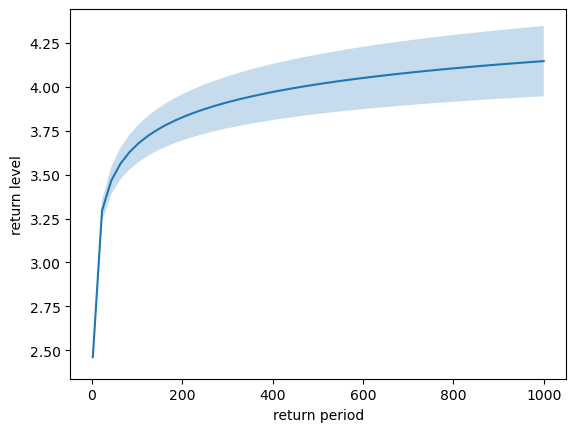

In [245]:
gev.return_level_plot(include_ci=True,log_scale=False)

In [186]:
gpd = GPDMLE(u=2.0)
gpd.fit(x_data)
gpd.get_params(include_ci=True)
gpd.return_level_se(100.0, period=100)

array(0.05671731)

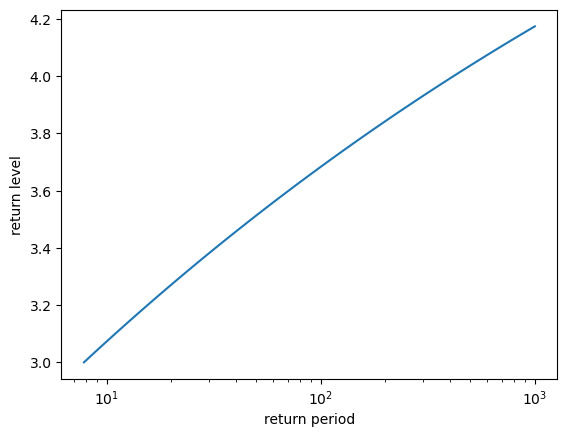

In [185]:
gpd.return_level_plot(period=100)

In [204]:
gpd.return_level(10.0, period=100)

3.072764127542478

In [205]:
gev.return_level(10)

3.0620878810428316

In [ ]:
class GEVMLE_ts(GEVMLE):

    def __init__(self, period_str=100):
       
        period = {
            'year'  : 365.25,
            'month' : 365.25/12,
        }

        self.period_str = period_str

        super().__init__(period[period_str])


In [250]:
365.25/12

30.4375